## **SKENARIO 1: Klasifikasi KNN - Full Fitur**

## **IMPORT LIBRARY**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## **DATA LOADING**

In [50]:
# Load dan read data
url_train = "https://drive.google.com/uc?export=download&id=1mwBc1Xbdp5vezgcQLi-BWcsaVNxiqblv"
url_test = "https://drive.google.com/uc?export=download&id=1nSQr83pGwZQ-ShLgrDWH0AoPEi3E5FgF"
url_label = "https://drive.google.com/uc?export=download&id=169-NXQYAKyntsfhcEjzWc0oNB4dD4DkQ"

df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_label = pd.read_csv(url_label)

In [51]:
# Menggabungkan fitur train dan label 
df = pd.concat([df_train, df_label], axis=1)
print(f"Dataset Loaded\nDimensi: {df.shape}")

Dataset Loaded
Dimensi: (3817, 17)


## **PREPROCESSING**

### - **Data Cleaning**

In [52]:
# Drop fitur tanggal yang rusak parah
df_clean = df.drop(columns=['tanggal_menjadi_anggota'])

In [53]:
# Ganti noise '5' dengan NaN agar dianggap missing value
cols_with_noise = ['pendidikan', 'status_pernikahan']
for col in cols_with_noise:
    df_clean[col] = df_clean[col].replace('5', np.nan)

In [54]:
# Memisahkan Fitur (X) dan Target (y)
target_col = 'jumlah_promosi'
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [55]:
# Melakukan Split data
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Split Done. \nTrain Shape: {X_train_raw.shape}, Val Shape: {X_val_raw.shape}")

Data Split Done. 
Train Shape: (3053, 15), Val Shape: (764, 15)


In [56]:
X_train_clean = X_train_raw.copy()
X_val_clean = X_val_raw.copy()

In [57]:
# Imputasi Missing Values

# Numeric (Median)
imputer_num = SimpleImputer(strategy='median')
X_train_clean[num_cols] = imputer_num.fit_transform(X_train_clean[num_cols])
X_val_clean[num_cols] = imputer_num.transform(X_val_clean[num_cols])

# Categorical (Mode)
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_clean[cat_cols] = imputer_cat.fit_transform(X_train_clean[cat_cols])
X_val_clean[cat_cols] = imputer_cat.transform(X_val_clean[cat_cols])


X_train_imp = pd.DataFrame(X_train_clean, columns=X_train_clean.columns, index=X_train_raw.index)
X_val_imp = pd.DataFrame(X_val_clean, columns=X_val_clean.columns, index=X_val_raw.index)

print("Missing Value Imputation Selesai")

Missing Value Imputation Selesai


In [58]:
X_train_imp.isna().sum()

tahun_kelahiran       0
pendidikan            0
status_pernikahan     0
pendapatan            0
jumlah_anak_balita    0
jumlah_anak_remaja    0
terakhir_belanja      0
belanja_buah          0
belanja_daging        0
belanja_ikan          0
belanja_kue           0
pembelian_diskon      0
pembelian_web         0
pembelian_toko        0
keluhan               0
dtype: int64

In [59]:
X_val_imp.isna().sum()

tahun_kelahiran       0
pendidikan            0
status_pernikahan     0
pendapatan            0
jumlah_anak_balita    0
jumlah_anak_remaja    0
terakhir_belanja      0
belanja_buah          0
belanja_daging        0
belanja_ikan          0
belanja_kue           0
pembelian_diskon      0
pembelian_web         0
pembelian_toko        0
keluhan               0
dtype: int64

### - **FEATURE TRANSFORMATION**

In [60]:
# Melakukan encoding
X_train_enc = X_train_imp.copy()
X_val_enc = X_val_imp.copy()

# Ordinal Mapping (Pendidikan)
education_map = {'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5}
X_train_enc['pendidikan'] = X_train_enc['pendidikan'].map(education_map)
X_val_enc['pendidikan'] = X_val_enc['pendidikan'].map(education_map)

# One-Hot Encoding (Status Pernikahan)
X_train_enc = pd.get_dummies(X_train_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = pd.get_dummies(X_val_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoding selesai")

Encoding selesai


In [61]:
# Handling High Skewness Distribution
def classify_skewness(skew_value):
    abs_skew = abs(skew_value)

    if abs_skew <= 0.5:
        return "Normal"
    elif abs_skew <= 1:
        return "Moderate"
    else:
        return "High"

skew_values = X_train_enc[num_cols].skew()
skew_summary = skew_values.reset_index()
skew_summary.columns = ["feature", "skewness"]
skew_summary["skew_category"] = skew_summary["skewness"].apply(classify_skewness)

skew_summary

,feature,skewness,skew_category
0,tahun_kelahiran,-0.308181,Normal
1,pendapatan,-0.040731,Normal
2,jumlah_anak_balita,1.219777,High
3,jumlah_anak_remaja,0.899724,Moderate
4,terakhir_belanja,0.114114,Normal
5,belanja_buah,1.801325,High
6,belanja_daging,1.668111,High
7,belanja_ikan,1.698658,High
8,belanja_kue,1.803451,High
9,pembelian_diskon,1.675188,High


In [62]:
moderate_skew_features = skew_summary.loc[
    skew_summary["skew_category"] == "Moderate",
    "feature"
].tolist()

high_skew_features = skew_summary.loc[
    skew_summary["skew_category"] == "High",
    "feature"
].tolist()

negative_features = [
    col for col in high_skew_features
    if (df_train[col] < 0).any()
]

print("Features with negative values:", negative_features)

Features with negative values: []


In [63]:
X_train_skew = X_train_enc.copy()
X_val_skew = X_val_enc.copy()

for col in high_skew_features:
    X_train_skew[col] = np.log1p(X_train_skew[col])
    X_val_skew[col] = np.log1p(X_val_skew[col])

for col in moderate_skew_features:
    X_train_skew[col] = np.log1p(X_train_skew[col])
    X_val_skew[col] = np.log1p(X_val_skew[col])

print("Skewness handling selesai")

Skewness handling selesai


In [64]:
# Handling Outliers 
X_train_out = X_train_skew.copy()
X_val_out = X_val_skew.copy()

def detect_outliers_iqr(series, factor):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    return (series < lower_bound) | (series > upper_bound)


outlier_summary = []

for col in high_skew_features:
    mild_outliers = detect_outliers_iqr(X_train_out[col], factor=1.5)
    extreme_outliers = detect_outliers_iqr(X_train_out[col], factor=3)
    very_extreme_outliers = detect_outliers_iqr(X_train_out[col], factor=5)

    outlier_summary.append({
        "feature": col,

        "mild_outlier_pct (%)": mild_outliers.mean() * 100,
        "extreme_outlier_pct (%)": extreme_outliers.mean() * 100,
        "very_extreme_outlier_pct (%)": very_extreme_outliers.mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df


,feature,mild_outlier_pct (%),extreme_outlier_pct (%),very_extreme_outlier_pct (%)
0,jumlah_anak_balita,0.000000,0.000000,0.000000
1,belanja_buah,5.699312,5.273501,0.000000
2,belanja_daging,0.818867,0.622339,0.000000
3,belanja_ikan,6.157877,5.633803,0.000000
4,belanja_kue,8.712742,8.483459,0.000000
5,pembelian_diskon,0.294792,0.000000,0.000000
6,keluhan,0.524075,0.524075,0.524075


In [ ]:
# Melakukan Scaling
scaler = StandardScaler()
X_train_final = pd.DataFrame(
    scaler.fit_transform(X_train_out),
    columns=X_train_out.columns,
    index=X_train_out.index
)

X_val_final = pd.DataFrame(
    scaler.transform(X_val_out),
    columns=X_val_out.columns,
    index=X_val_out.index
)

print("Scaling selesai")

Scaling selesai


In [66]:
X_train_final.head()

,tahun_kelahiran,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
700,-0.923654,-0.312905,-0.066778,-0.609764,1.400883,0.641347,0.262330,0.180640,-0.039949,-0.554014,1.324242,0.166834,0.412905,-0.072583,-0.245841,-0.110761,-0.649093,1.266866,-0.578233
2044,0.954127,-0.312905,0.026680,-0.609764,-0.691997,-1.319211,0.073212,-1.432990,-0.822434,0.211824,0.256452,-0.164588,-1.178760,-0.072583,-0.245841,-0.110761,-0.649093,1.266866,-0.578233
644,-1.350422,1.942821,1.345417,-0.609764,-0.691997,-0.753666,0.680878,1.054573,0.697714,0.847145,0.256452,0.166834,1.367904,-0.072583,4.067675,-0.110761,-0.649093,-0.789350,-0.578233
3218,0.271298,-0.312905,-0.277274,-0.609764,2.625138,0.603644,0.964578,0.653186,0.712940,0.869777,0.699625,1.196325,2.004569,-0.072583,-0.245841,-0.110761,1.540610,-0.789350,-0.578233
3393,-0.667593,-0.312905,0.909034,-0.609764,-0.691997,-1.432321,0.808079,0.397460,0.677019,0.464588,0.256452,1.337883,-0.542094,-0.072583,-0.245841,-0.110761,-0.649093,-0.789350,1.729407


In [67]:
X_val_final.head()

,tahun_kelahiran,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
2561,-1.350422,-0.312905,0.082118,-0.609764,1.400883,0.528238,-0.339095,-0.019983,-0.499826,0.339204,-0.368166,0.666576,1.367904,-0.072583,-0.245841,-0.110761,-0.649093,1.266866,-0.578233
1425,-0.155471,-0.312905,0.915660,-0.609764,-0.691997,-1.168399,1.012801,0.760505,0.601554,0.650937,-1.435956,1.337883,-0.542094,-0.072583,-0.245841,-0.110761,1.540610,-0.789350,-0.578233
2185,1.722311,-0.312905,-1.756993,-0.609764,-0.691997,-1.733945,-0.015965,-1.092113,-0.046030,-0.405757,-0.368166,-2.223570,-1.497093,-0.072583,-0.245841,-0.110761,-0.649093,-0.789350,1.729407
2519,0.442005,-0.312905,-0.828094,1.575751,-0.691997,1.508517,-0.097430,-0.656320,0.000595,-2.959537,-0.368166,0.437625,-0.860427,-0.072583,-0.245841,-0.110761,-0.649093,-0.789350,1.729407
3045,1.380896,-0.312905,0.854866,-0.609764,-0.691997,1.621626,0.881577,0.909801,0.590185,0.869639,-0.368166,1.196325,0.412905,-0.072583,-0.245841,-0.110761,1.540610,-0.789350,-0.578233


## **MANUAL CALCULATION**

In [68]:
train_sample = X_train_final.iloc[:5]
val_sample = X_val_final.iloc[:1]

In [69]:
dists = []
for i in range(len(train_sample)):
    # Euclidean Distance
    d = np.linalg.norm(train_sample.iloc[i] - val_sample.iloc[0])
    dists.append(d)

In [70]:
# untuk k=3
manual_res = pd.DataFrame({
    'Train_Idx': train_sample.index, 
    'Dist': dists, 
    'Label': y_train.iloc[:5].values
}).sort_values('Dist')
manual_res.head(3)

,Train_Idx,Dist,Label
0,700,2.377896,4
3,3218,4.360921,0
1,2044,4.791722,1


## **MODELING**


Mencari nilai K terbaik...
Best K: 1, Best Metric: euclidean, Best Weights: distance dengan akurasi: 0.5615


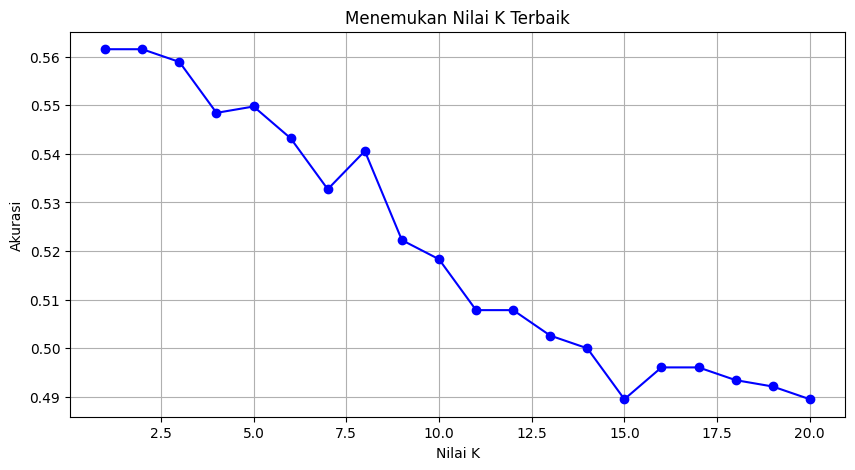

In [71]:
# Menentukan Best parameter K
best_acc = 0
best_k = 1
accuracies = []

print("\nMencari nilai K terbaik...")
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_final, y_train)

    y_pred = knn.predict(X_val_final)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        best_k = k
        best_metric = knn.metric
        best_weights = knn.weights
    


print(f"Best K: {best_k}, Best Metric: {best_metric}, Best Weights: {best_weights} dengan akurasi: {best_acc:.4f}")

# Visualisasi K
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), accuracies, marker='o', linestyle='-', color='b')
plt.title('Menemukan Nilai K Terbaik')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi')
plt.grid(True)
plt.show()

In [72]:
# Training
knn_final = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights, metric=best_metric)
knn_final.fit(X_train_final, y_train)
y_pred = knn_final.predict(X_val_final)

## **EVALUATION**

              precision    recall  f1-score   support

           0       0.57      0.44      0.49       195
           1       0.46      0.30      0.36       120
           2       0.46      0.47      0.47        79
           3       0.58      0.74      0.65        84
           4       0.61      0.82      0.70        91
           5       0.67      0.77      0.72       120
           6       0.47      0.56      0.51        75

    accuracy                           0.56       764
   macro avg       0.55      0.58      0.56       764
weighted avg       0.55      0.56      0.55       764



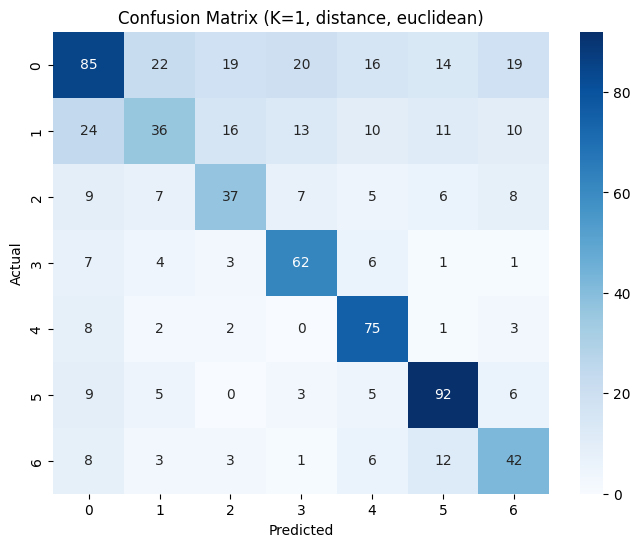

In [73]:
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (K={best_k}, {knn_final.weights}, {knn_final.metric})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **HYPERPARAMETER TUNNING**

In [74]:
print("\n" + "="*40)
print("MEMULAI PENCARIAN PARAMETER TERBAIK...")
print("="*40)

best_score = 0
best_k = 0
best_weight = ''
best_metric = ''

# K dari 1 sampai 30
# weight: uniform (sama rata) dan distance (yang dekat lebih berpengaruh)
# metric: euclidean, manhattan, minkowski
for k in range(1, 31):
    for weight in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan', 'minkowski']:
            knn_tuning = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            knn_tuning.fit(X_train_final, y_train)
            score = knn_tuning.score(X_val_final, y_val)
            
            if score > best_score:
                best_score = score
                best_k = k
                best_weight = weight
                best_metric = metric

print(f"Parameter Terbaik Ditemukan:")
print(f"  - K (Jumlah Tetangga): {best_k}")
print(f"  - Weights (Bobot): {best_weight}")
print(f"  - Metric (Jarak): {best_metric}")
print(f"  - Akurasi Tertinggi: {best_score:.4f}")


MEMULAI PENCARIAN PARAMETER TERBAIK...
Parameter Terbaik Ditemukan:
  - K (Jumlah Tetangga): 1
  - Weights (Bobot): uniform
  - Metric (Jarak): manhattan
  - Akurasi Tertinggi: 0.6348



Classification Report (Model Optimal):
              precision    recall  f1-score   support

           0       0.66      0.52      0.58       195
           1       0.48      0.35      0.41       120
           2       0.55      0.53      0.54        79
           3       0.63      0.82      0.71        84
           4       0.67      0.92      0.78        91
           5       0.72      0.80      0.76       120
           6       0.65      0.68      0.67        75

    accuracy                           0.63       764
   macro avg       0.62      0.66      0.63       764
weighted avg       0.63      0.63      0.62       764



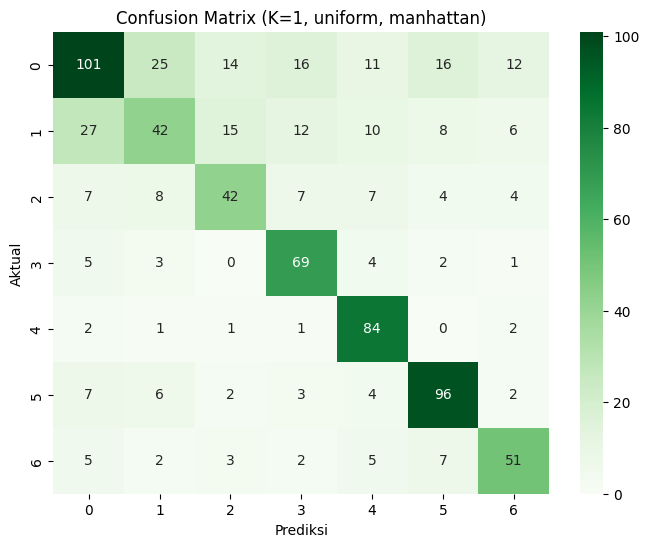

In [75]:
# evaluasi model dengan parameter terbaik
final_model = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight, metric=best_metric)
final_model.fit(X_train_final, y_train)
final_pred = final_model.predict(X_val_final)

print("\nClassification Report (Model Optimal):")
print(classification_report(y_val, final_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, final_pred), annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix (K={best_k}, {best_weight}, {best_metric})')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()